In [276]:
import numpy as np
import tensorflow as tf
import keras_nlp
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [180]:
# data loading

with gzip.open('../data/segment_with_noise/ll_seg_gps_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_gps_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gps_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gps_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,y_norm,x_norm,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.795350,0.203490
43617,42.246167,-83.563112,0.785304,0.204631,0.787305,0.203073
43667,42.246155,-83.563137,0.784089,0.202890,0.788982,0.203170
43717,42.246143,-83.563163,0.782877,0.201164,0.794082,0.195338
43767,42.246131,-83.563188,0.781676,0.199454,0.791014,0.203958


In [192]:
ll_seg_gps_noise[0][['y_norm_noise', 'x_norm_noise']].values[0]

array([0.79535004, 0.20348973])

In [234]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
# y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    x_ll.append(df[['y_norm_noise', 'x_norm_noise']].values)
    # y_gps_ll.append(df[['y_norm', 'x_norm']].values)
    # y_ll.append(list(df[['y_norm', 'x_norm']].itertuples(index=False, name=None)))

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)
    # y_ll.append(list(df[['y_norm', 'x_norm']].itertuples(index=False, name=None)))

In [235]:
# 500 segment samples with length 77
len(x_ll), len(x_ll[0])

(500, 77)

In [236]:
len(x_ll[0]), len(x_ll[2])

(77, 77)

In [237]:
# 500 segment samples with length 3822
len(y_ll), len(y_ll[0])

(500, 3822)

In [238]:
np.array([0.1, 0.2, 0.3]).reshape((1,3,1))

array([[[0.1],
        [0.2],
        [0.3]]])

## model 1: LSTM based seq2seq model

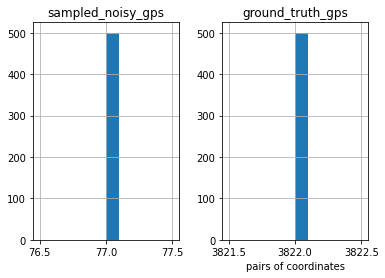

In [246]:
x_count = []
y_count = []

for x_seg in x_ll:
    x_count.append(len(x_seg))
for y_seg in y_ll:
    y_count.append(len(y_seg))

graph_df = pd.DataFrame() 

graph_df['sampled_noisy_gps'] = x_count
graph_df['ground_truth_gps'] = y_count

graph_df.hist(bins = 10)
plt.xlabel('pairs of coordinates')
plt.show()

In [240]:
# selecting max_y_len and max_x_len
max_x_len = max([len(x_seg) for x_seg in x_ll])
max_y_len = max([len(y_seg) for y_seg in y_ll])

max_y_len, max_x_len

(3822, 77)

In [302]:
x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
y_temp = np.asarray([np.arange(max_y_len) for i in np.arange(len(y_ll))])

x_train_temp, x_val_temp = train_test_split(x_temp, test_size=0.1, random_state=0)
y_train_temp, y_val_temp = train_test_split(y_temp, test_size=0.1, random_state=0)

print(x_train_temp.shape, x_val_temp.shape)
x_train_temp

(450, 77) (50, 77)


array([[ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       ...,
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76]])

In [297]:
x_train, x_val, y_train, y_val = train_test_split(
    np.asarray(x_ll),
    np.asarray(y_ll),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)
x_train.shape, x_val.shape

((450, 77, 2), (50, 77, 2))

In [212]:
# batch, seq_length, embedd_length
(Dense(64, )(x_train) + Embedding(max_x_len+1, 64, input_length=max_x_len+1)(x_train_temp)).shape

TensorShape([450, 77, 64])

In [292]:
embedding_dim = 64
latent_dim = 300

### network architecture

In [317]:
# assuming all input trajectories have shape 77x2
x_train_input = Input(shape=(77,2,))
# dense layer of spatial embedding
spatial_embedd = Dense(embedding_dim) 

x_train_temp_input = Input(shape=(77,))
# temporal embedding
x_temporal_embedd = Embedding(max_x_len+1, embedding_dim, input_length=max_x_len+1, trainable=True) 

# combining two features to get spatio-temporal feature representation of input trajectory
x_h_st = Add()([spatial_embedd(x_train_input), x_temporal_embedd(x_train_temp_input)])

# Encoder
## Encoder LSTM 1
encoder_lstm1 = LSTM(
    latent_dim, return_sequences=True,
    return_state=True, dropout=0.2,
    recurrent_dropout=0.2
)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(x_h_st)

## Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

## Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)


# Decoder, assuming all target trajectories have shape 3822x2
y_train_input = Input(shape=(3821,2,))
spatial_embedd = Dense(embedding_dim)

y_train_temp_input = Input(shape=(3821,))
y_temporal_embedd = Embedding(max_y_len+1, embedding_dim, input_length=max_y_len+1, trainable=True)

y_h_st = Add()([spatial_embedd(y_train_input), y_temporal_embedd(y_train_temp_input)])

decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.2,
                    recurrent_dropout=0.1)

(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(y_h_st, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(2, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model(inputs=[x_train_input, x_train_temp_input, y_train_input, y_train_temp_input], outputs=decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [318]:
print(model.summary())

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 77, 2)]      0           []                               
                                                                                                  
 input_66 (InputLayer)          [(None, 77)]         0           []                               
                                                                                                  
 dense_61 (Dense)               (None, 77, 64)       192         ['input_65[0][0]']               
                                                                                                  
 embedding_42 (Embedding)       (None, 77, 64)       4992        ['input_66[0][0]']               
                                                                                           

In [322]:
# runtime ~= 50min es at epoch = 28

x_train = np.asarray(x_ll)
y_train = np.asarray(y_ll)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(
    [x_train, x_train_temp, y_train[:, :-1], y_train_temp[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 2)[:, 1:],
    # validation_data=[[x_val, x_val_temp, y_val, y_val_temp]],
    validation_split=0.2,
    batch_size=32, epochs=100, verbose='auto', callbacks=[es]
)

Epoch 1/100
13/13 [==============================] - 97s 7s/step - loss: 0.5902 - accuracy: 0.9706 - val_loss: 0.6302 - val_accuracy: 0.9810
Epoch 2/100
13/13 [==============================] - 98s 8s/step - loss: 0.5872 - accuracy: 0.9859 - val_loss: 0.6294 - val_accuracy: 0.9967
Epoch 3/100
13/13 [==============================] - 96s 7s/step - loss: 0.5904 - accuracy: 0.9861 - val_loss: 0.6328 - val_accuracy: 0.9674
Epoch 4/100
13/13 [==============================] - 96s 7s/step - loss: 0.5891 - accuracy: 0.9757 - val_loss: 0.6304 - val_accuracy: 0.9646
Epoch 5/100
13/13 [==============================] - 97s 7s/step - loss: 0.5867 - accuracy: 0.9756 - val_loss: 0.6286 - val_accuracy: 0.9906
Epoch 6/100
13/13 [==============================] - 94s 7s/step - loss: 0.5855 - accuracy: 0.9902 - val_loss: 0.6292 - val_accuracy: 0.9957
Epoch 7/100
13/13 [==============================] - 95s 7s/step - loss: 0.5857 - accuracy: 0.9908 - val_loss: 0.6288 - val_accuracy: 0.9958
Epoch 8/100
1

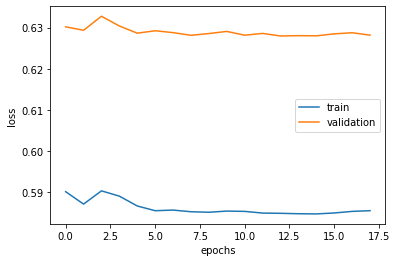

In [323]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

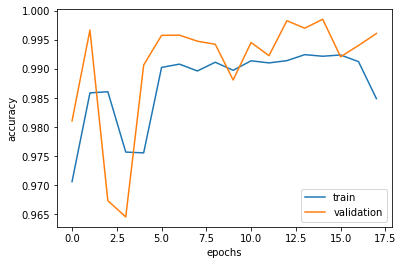

In [325]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('../models/v1')
model = keras.models.load_model('../models/v1')

INFO:tensorflow:Assets written to: ../models/v1/assets
